# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.486852,False,-6.932823
1,-0.957437,True,2.658591
2,-0.580901,False,-2.733626
3,-1.767096,False,-6.022463
4,-1.021941,False,-3.474791
...,...,...,...
995,-0.489841,False,-0.351721
996,-1.485929,False,-5.193868
997,-0.655330,False,-0.914420
998,-0.131957,False,-0.724904


<AxesSubplot:xlabel='v0'>

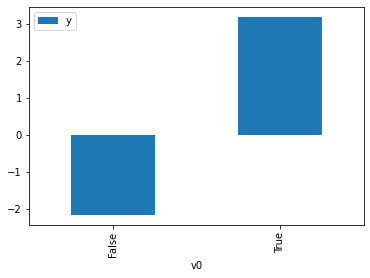

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

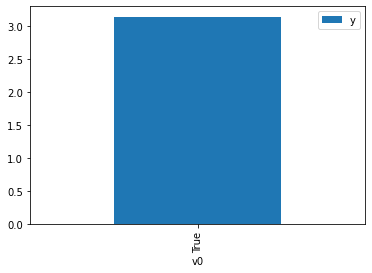

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.382006,False,0.513533,0.614905,1.626268
1,-1.032307,False,-2.561423,0.762215,1.311966
2,-0.787120,False,-2.210785,0.711383,1.405712
3,-0.988054,False,-4.761852,0.753513,1.327116
4,-1.632724,False,-6.369655,0.859155,1.163934
...,...,...,...,...,...
995,-1.488386,False,-5.434311,0.839379,1.191358
996,-1.834066,False,-5.452918,0.883300,1.132119
997,-0.104747,False,-0.933714,0.542610,1.842944
998,-0.247487,False,0.436043,0.580255,1.723380


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.291825,True,6.313530,0.563192,1.775595
1,0.829483,True,7.408275,0.696418,1.435919
2,-0.868414,True,1.558688,0.271065,3.689157
3,-1.507360,True,0.976104,0.157899,6.333170
4,-0.957437,True,2.658591,0.252631,3.958340
...,...,...,...,...,...
995,-0.308944,True,4.142326,0.403794,2.476509
996,-0.983130,True,2.151669,0.247468,4.040925
997,-0.209071,True,4.760823,0.429804,2.326644
998,0.135489,True,6.167573,0.521634,1.917053


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.076e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:08:29   Log-Likelihood:                         -1412.4
No. Observations:                1000   AIC:                                      2829.
Df Residuals:                     998   BIC:                                      2839.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.0085      0.026    116.043      0.000       2.958       3.059
x2             4.9934      0.053     93.746      0.000       4.889       5.098
==============================================================================
Omnibus:                        1.620   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.549
Skew:                           0.015   Prob(JB):                        0.461
Kurtosis:                       2.809   Cond. No.                         2.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""